# Análise de Sentimento para Revisões de Filmes

## Segundo Exercício Prático


Neste TP você deve explorar a base de dados para análise de sentimento sobre um filme (`rotten tomatoes`). Você não precisa rodar nenhum algoritmo de Aprendizagem de Máquina para obter uma acurácia sobre o sentimento das pessoas sobre o filme. No entanto, você deve utilizar os conceitos discutidos na primeira e segunda aula para explorar a base de dados e garantir que ela esteja pronta para algum algoritmo.

Neste caso, o aluno deve obrigatoriamente utilizar dois algoritmos para vetorizar a base de dados:

1. CountVectorizer e TfidfVectorizer, ambos estão disponíveis no Scikit Learn do Python, mas você pode utilizar qualquer implementação que resolva o problema
2. Gere gráficos interessantes, por exemplo, das palavras mais frequentes sobre cada sentimento (negativo, pouco negativo, neutro, pouco positivo, positivo)
3. Pelo menos lemmatize os tokens.
4. Um extra interessante para o seu TP pode ser a aplicação de uma nuvem de palavras (word cloud)

O dataset se encontra na pasta `data` dentro deste mesmo diretório, o arquivo de treino se chama `train-movie.csv` e o arquivo de teste se chama `test-movie.csv`.

As classes do dataset são as seguintes:

* 0 - *negativo*
* 1 - *pouco negativo*
* 2 - *neutral*
* 3 - *pouco positivo*
* 4 - *positivo*

In [1]:
# bibliotecas 
import pandas as pd
import numpy as np
import nltk
import operator
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

%matplotlib inline

### O dataset utilizado pode ser chamado assim

In [2]:
df_train = pd.read_csv("data/train-movie.tsv", sep='\t')
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


Observe que as colunas PhraseId e Sentence Id não são necessárias para nossa análise

In [3]:
df_train.describe()

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


In [4]:
df_test = pd.read_csv("data/test-movie.tsv", sep='\t')
df_test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


O conjunto de teste não será necessário para essa parte do TP, mas você pode analisar se preferir

In [5]:
df_test.describe()

,PhraseId,SentenceId
count,66292.00000,66292.000000
mean,189206.50000,10114.909144
std,19136.99636,966.787807
min,156061.00000,8545.000000
25%,172633.75000,9266.000000
50%,189206.50000,10086.000000
75%,205779.25000,10941.000000
max,222352.00000,11855.000000


### Distribuição das classes

In [6]:
df_train.Sentiment.value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [7]:
print((df_train.Sentiment.value_counts()/df_train.shape[0])*100)

2    50.994489
3    21.098936
1    17.475971
4     5.899013
0     4.531590
Name: Sentiment, dtype: float64


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
PhraseId      156060 non-null int64
SentenceId    156060 non-null int64
Phrase        156060 non-null object
Sentiment     156060 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


## Trabalho

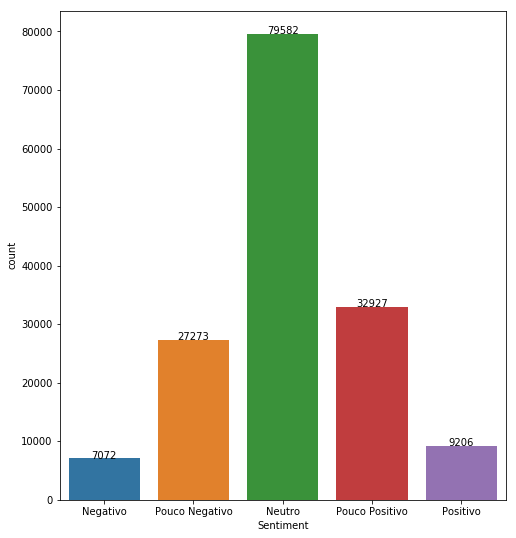

In [31]:
plt.figure(figsize=(8,9))
ax=sns.countplot(x='Sentiment',data=df_train)

labels = ['Negativo','Pouco Negativo','Neutro','Pouco Positivo','Positivo']
ax.set_xticklabels(labels)
sizes = []
for p in ax.patches:
    height = p.get_height()
    sizes.append(p.get_height())
    if(np.isnan(height)):
        height=0   
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            height,
            ha="center")

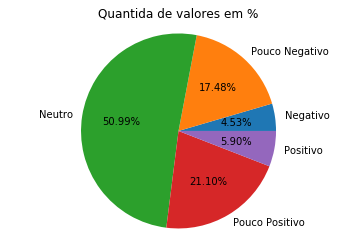

In [42]:
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.2f%%')
ax.axis('equal')
ax.set_title("Quantida de valores em %")
plt.show()

In [10]:
# Tokenização das frases.
# O processo tem como objetivo separar palavras ou sentenças em unidades.
df_train['Tokens'] = df_train.apply(lambda row: word_tokenize(row['Phrase']), axis=1)

# Convertendo para minúsculo.
df_train['Tokens'] = df_train.apply(lambda row: map(lambda x:x.lower(),row['Tokens']),axis=1)

df_train['Tokens'].head()

0    <map object at 0x7f16715d6cc0>
1    <map object at 0x7f16715d6da0>
2    <map object at 0x7f16715d6e10>
3    <map object at 0x7f16715d6e80>
4    <map object at 0x7f16715d6f28>
Name: Tokens, dtype: object

O processo de stemização (do inglês, stemming) consiste em reduzir uma palavra ao seu radical. A palavra “meninas” se reduziria a “menin”, assim como “meninos” e “menininhos”. As palavras “gato”, “gata”, “gatos” e “gatas” reduziriam-se para “gat”.

In [11]:
# Removendo pontuação
pont = ['.',',',':','``','--','','\'s','\'','&','$','#','\'\'','`']

def remove_pont(mylist):
    return [w for w in mylist if not w in pont]

df_train['Tokens'] = df_train.apply(lambda row: remove_pont(row['Tokens']), axis=1)

A lematização reduz a palavra ao seu lema, que é a forma no masculino e singular. No caso de verbos, o lema é o infinitivo. Por exemplo, as palavras “gato”, “gata”, “gatos” e “gatas” são todas formas do mesmo lema: “gato”. Igualmente, as palavras “tiver”, “tenho”, “tinha”, “tem” são formas do mesmo lema “ter”.

In [12]:
# Lematização dos tokens
lemmatizer = WordNetLemmatizer()

def lemmatize_func(mylist):
    return [lemmatizer.lemmatize(w) for w in mylist]

df_train['Tokens'] = df_train.apply(lambda row: lemmatize_func(row['Tokens']), axis=1)

df_train['Tokens'].head()

0    [a, series, of, escapade, demonstrating, the, ...
1    [a, series, of, escapade, demonstrating, the, ...
2                                          [a, series]
3                                                  [a]
4                                             [series]
Name: Tokens, dtype: object

In [13]:
word_list = []
for indes, value in df_train['Tokens'].iteritems():
    word_list.extend(value)

vocab = set(word_list)

vocab_set = sorted(vocab)

In [14]:
# Criando um dicionario com a frequencia das palavras.
vocab_freq = dict()

for value in vocab_set:
    vocab_freq[value] = 0

for index, item in df_train['Tokens'].iteritems():
    for word in item:
        vocab_freq[word] = vocab_freq[word] + 1

vocab_freq

{'!': 248,
 "'30s": 16,
 "'40s": 15,
 "'50s": 34,
 "'53": 7,
 "'60s": 51,
 "'70s": 68,
 "'80s": 13,
 "'90s": 13,
 "'d": 293,
 "'em": 72,
 "'ll": 484,
 "'m": 211,
 "'re": 812,
 "'til": 8,
 "'ve": 563,
 '+': 11,
 '-': 761,
 '-lrb-': 2098,
 '-rrb-': 2438,
 '...': 1884,
 '1': 37,
 '1.2': 13,
 '1.8': 17,
 '10': 117,
 '10,000': 12,
 '10-course': 7,
 '10-year': 15,
 '10-year-old': 10,
 '100': 48,
 '100-minute': 15,
 '100-year': 7,
 '101': 42,
 '102-minute': 16,
 '103-minute': 15,
 '104': 15,
 '105': 12,
 '10th': 5,
 '10th-grade': 11,
 '11': 38,
 '110': 17,
 '112-minute': 9,
 '12': 14,
 '12-year-old': 31,
 '120': 7,
 '127': 10,
 '129-minute': 9,
 '12th': 10,
 '13': 39,
 '13th': 13,
 '14-year-old': 13,
 '140': 8,
 '146': 15,
 '15': 67,
 '15-year': 11,
 '15th': 8,
 '163': 13,
 '168-minute': 8,
 '170': 19,
 '1790': 12,
 '18': 15,
 '18-year-old': 24,
 '1899': 6,
 '19': 5,
 '1915': 16,
 '1920': 16,
 '1930s': 7,
 '1933': 9,
 '1937': 10,
 '1938': 12,
 '1940s': 16,
 '1950': 10,
 '1950s': 28,
 '1952': 

In [15]:
print("Número de palavras únicas no dataset: " + str(len(vocab_set)))
sorted_vocab_freq = list(reversed(sorted(vocab_freq.items(), key = operator.itemgetter(1))))
print("Top 50 palavras mais frequentes: " + str(sorted_vocab_freq[:50]))

Número de palavras únicas no dataset: 15178
Top 50 palavras mais frequentes: [('the', 51220), ('a', 44748), ('of', 32308), ('and', 31763), ('to', 22448), ('it', 18728), ('in', 13754), ('is', 13447), ('that', 12327), ('with', 7750), ('film', 7668), ('for', 7417), ('movie', 7250), ('an', 6479), ('this', 5677), ('but', 5126), ('be', 4977), ('you', 4827), ('on', 4730), ("n't", 3970), ('by', 3918), ('more', 3906), ('his', 3827), ('one', 3783), ('about', 3682), ('not', 3562), ('at', 3550), ('or', 3472), ('from', 3462), ('than', 3458), ('all', 3201), ('have', 3134), ('like', 3092), ('are', 3059), ('ha', 2950), ('character', 2850), ('story', 2831), ('so', 2644), ('-rrb-', 2438), ('make', 2415), ('out', 2380), ('who', 2359), ('time', 2293), ('most', 2227), ('into', 2163), ('too', 2143), ('up', 2104), ('-lrb-', 2098), ('good', 2066), ('if', 1979)]


In [16]:
sentences = []
sentid = 0
sentlabels = []
for index, row in df_train.iterrows():
    if(sentid != row['SentenceId']):
        sentid = row['SentenceId']
        sentlabels.append(row['Sentiment'])
        sentences.append(row['Tokens'])

sentences

[['a',
  'series',
  'of',
  'escapade',
  'demonstrating',
  'the',
  'adage',
  'that',
  'what',
  'is',
  'good',
  'for',
  'the',
  'goose',
  'is',
  'also',
  'good',
  'for',
  'the',
  'gander',
  'some',
  'of',
  'which',
  'occasionally',
  'amuses',
  'but',
  'none',
  'of',
  'which',
  'amount',
  'to',
  'much',
  'of',
  'a',
  'story'],
 ['this',
  'quiet',
  'introspective',
  'and',
  'entertaining',
  'independent',
  'is',
  'worth',
  'seeking'],
 ['even',
  'fan',
  'of',
  'ismail',
  'merchant',
  'work',
  'i',
  'suspect',
  'would',
  'have',
  'a',
  'hard',
  'time',
  'sitting',
  'through',
  'this',
  'one'],
 ['a',
  'positively',
  'thrilling',
  'combination',
  'of',
  'ethnography',
  'and',
  'all',
  'the',
  'intrigue',
  'betrayal',
  'deceit',
  'and',
  'murder',
  'of',
  'a',
  'shakespearean',
  'tragedy',
  'or',
  'a',
  'juicy',
  'soap',
  'opera'],
 ['aggressive', 'self-glorification', 'and', 'a', 'manipulative', 'whitewash'],
 ['a

In [17]:
# Criando um coluna para tokenize
#df2['tokenize'] = df2['Phrase'].apply(word_tokenize)
df_train.columns

Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment', 'Tokens'], dtype='object')

In [78]:
df_copy = df_train[['Phrase', 'Sentiment']].copy()
df_copy.head()

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2


In [79]:
# Criando uma lista de stopwords
lista_stop = nltk.corpus.stopwords.words('english')
np.transpose(lista_stop)

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

In [20]:
# funcao para remover stopwords
def removeStopWords(text):
    frases = []
    for(palavras, sent) in text:
        semStop = [p for p in palavras.split() if p not in lista_stop]
        frases.append((semStop, sent))
    return frases

In [21]:
df_copy['Phrase'] = df_copy['Phrase'].apply(word_tokenize)

In [80]:
df_copy.head()

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2


In [98]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

In [106]:
# Kaggle https://www.kaggle.com/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments
# Initialize a CountVectorizer object: count_vectorizer
count_vec = CountVectorizer(stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None)


In [109]:
# Transforms the data into a bag of words
count_train = count_vec.fit(df_copy['Phrase'])
bag_of_words = count_vec.transform(df_copy['Phrase'])

In [110]:
# Print the first 10 features of the count_vec
print("Every feature:\n{}".format(count_vec.get_feature_names()))
print("\nEvery 3rd feature:\n{}".format(count_vec.get_feature_names()[::3]))

Every feature:
['000', '10', '100', '101', '102', '103', '104', '105', '10th', '11', '110', '112', '12', '120', '127', '129', '12th', '13', '13th', '14', '140', '146', '15', '15th', '16', '163', '168', '170', '1790', '18', '1899', '19', '1915', '1920', '1930s', '1933', '1937', '1938', '1940s', '1950', '1950s', '1952', '1953', '1957', '1958', '1959', '1960', '1960s', '1962', '1970', '1970s', '1971', '1972', '1973', '1975', '1979', '1980', '1980s', '1984', '1986', '1987', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1997', '1998', '1999', '19th', '20', '2000', '2001', '2002', '20th', '21', '21st', '22', '24', '2455', '25', '26', '270', '295', '30', '300', '3000', '30s', '37', '3d', '40', '40s', '42', '451', '48', '4ever', '4th', '4w', '50', '500', '50s', '51', '51st', '52', '53', '5ths', '60', '60s', '65', '65th', '66', '70', '70s', '71', '72', '75', '77', '78', '7th', '80', '800', '80s', '83', '84', '85', '86', '87', '88', '89', '8th', '90', '90s', '91', '93', '94', '95', '9

In [111]:
print("Vocabulary size: {}".format(len(count_train.vocabulary_)))
print("Vocabulary content:\n {}".format(count_train.vocabulary_))

Vocabulary size: 14955
Vocabulary content:
 {'series': 11645, 'escapades': 4504, 'demonstrating': 3432, 'adage': 285, 'good': 5720, 'goose': 5736, 'gander': 5497, 'occasionally': 9043, 'amuses': 584, 'amounts': 575, 'story': 12647, 'quiet': 10401, 'introspective': 7021, 'entertaining': 4427, 'independent': 6720, 'worth': 14818, 'seeking': 11562, 'fans': 4861, 'ismail': 7099, 'merchant': 8314, 'work': 14790, 'suspect': 12979, 'hard': 6054, 'time': 13408, 'sitting': 11959, 'positively': 9940, 'thrilling': 13358, 'combination': 2519, 'ethnography': 4547, 'intrigue': 7011, 'betrayal': 1304, 'deceit': 3295, 'murder': 8688, 'shakespearean': 11715, 'tragedy': 13557, 'juicy': 7274, 'soap': 12170, 'opera': 9127, 'aggressive': 425, 'self': 11582, 'glorification': 5675, 'manipulative': 8083, 'whitewash': 14644, 'comedy': 2532, 'drama': 3963, 'nearly': 8813, 'epic': 4461, 'proportions': 10222, 'rooted': 11160, 'performance': 9578, 'title': 13438, 'character': 2125, 'undergoing': 13895, 'midlife': 

In [90]:
count_vect = CountVectorizer()
x_count = count_vect.fit_transform(df_copy['Phrase'])

In [93]:
print(count_vect.get_feature_names())

['000', '10', '100', '101', '102', '103', '104', '105', '10th', '11', '110', '112', '12', '120', '127', '129', '12th', '13', '13th', '14', '140', '146', '15', '15th', '16', '163', '168', '170', '1790', '18', '1899', '19', '1915', '1920', '1930s', '1933', '1937', '1938', '1940s', '1950', '1950s', '1952', '1953', '1957', '1958', '1959', '1960', '1960s', '1962', '1970', '1970s', '1971', '1972', '1973', '1975', '1979', '1980', '1980s', '1984', '1986', '1987', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1997', '1998', '1999', '19th', '20', '2000', '2001', '2002', '20th', '21', '21st', '22', '24', '2455', '25', '26', '270', '295', '30', '300', '3000', '30s', '37', '3d', '40', '40s', '42', '451', '48', '4ever', '4th', '4w', '50', '500', '50s', '51', '51st', '52', '53', '5ths', '60', '60s', '65', '65th', '66', '70', '70s', '71', '72', '75', '77', '78', '7th', '80', '800', '80s', '83', '84', '85', '86', '87', '88', '89', '8th', '90', '90s', '91', '93', '94', '95', '96', '98', '99',

In [105]:
# TfidfVectorizer

In [57]:
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(df_copy['Phrase'])

In [58]:
print(vectorizer.get_feature_names())

['000', '10', '100', '101', '102', '103', '104', '105', '10th', '11', '110', '112', '12', '120', '127', '129', '12th', '13', '13th', '14', '140', '146', '15', '15th', '16', '163', '168', '170', '1790', '18', '1899', '19', '1915', '1920', '1930s', '1933', '1937', '1938', '1940s', '1950', '1950s', '1952', '1953', '1957', '1958', '1959', '1960', '1960s', '1962', '1970', '1970s', '1971', '1972', '1973', '1975', '1979', '1980', '1980s', '1984', '1986', '1987', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1997', '1998', '1999', '19th', '20', '2000', '2001', '2002', '20th', '21', '21st', '22', '24', '2455', '25', '26', '270', '295', '30', '300', '3000', '30s', '37', '3d', '40', '40s', '42', '451', '48', '4ever', '4th', '4w', '50', '500', '50s', '51', '51st', '52', '53', '5ths', '60', '60s', '65', '65th', '66', '70', '70s', '71', '72', '75', '77', '78', '7th', '80', '800', '80s', '83', '84', '85', '86', '87', '88', '89', '8th', '90', '90s', '91', '93', '94', '95', '96', '98', '99',

In [60]:
print(x.shape)

(156060, 15240)


In [113]:
tf = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')
txt_fitted = tf.fit(df_copy['Phrase'])
txt_transformed = txt_fitted.transform(df_copy['Phrase'])

In [114]:
tf.vocabulary_

{'series': 11837,
 'of': 9227,
 'escapades': 4577,
 'demonstrating': 3490,
 'the': 13505,
 'adage': 288,
 'that': 13503,
 'what': 14871,
 'is': 7217,
 'good': 5821,
 'for': 5323,
 'goose': 5837,
 'also': 529,
 'gander': 5595,
 'some': 12424,
 'which': 14888,
 'occasionally': 9204,
 'amuses': 602,
 'but': 1879,
 'none': 9085,
 'amounts': 593,
 'to': 13681,
 'much': 8807,
 'story': 12857,
 'this': 13556,
 'quiet': 10585,
 'introspective': 7143,
 'and': 625,
 'entertaining': 4500,
 'independent': 6840,
 'worth': 15096,
 'seeking': 11750,
 'even': 4642,
 'fans': 4942,
 'ismail': 7222,
 'merchant': 8449,
 'work': 15068,
 'suspect': 13190,
 'would': 15100,
 'have': 6210,
 'hard': 6156,
 'time': 13644,
 'sitting': 12159,
 'through': 13598,
 'one': 9272,
 'positively': 10123,
 'thrilling': 13591,
 'combination': 2573,
 'ethnography': 4621,
 'all': 506,
 'intrigue': 7133,
 'betrayal': 1348,
 'deceit': 3353,
 'murder': 8831,
 'shakespearean': 11909,
 'tragedy': 13799,
 'or': 9326,
 'juicy': 7400

In [115]:
# Frequencia inversa do documento
idf = tf.idf_
print(dict(zip(txt_fitted.get_feature_names(), idf)))

{'000': 9.822501611741602, '10': 7.770610021829997, '100': 8.709500585621393, '101': 9.220326209387384, '102': 10.18540710543097, '103': 10.249945626568541, '104': 10.249945626568541, '105': 10.473089177882752, '10th': 10.18540710543097, '11': 8.61419040581707, '110': 10.124782483614537, '112': 10.760771250334534, '12': 8.914944559836202, '120': 11.012085678615438, '127': 10.655410734676707, '129': 10.760771250334534, '12th': 10.655410734676707, '13': 8.709500585621393, '13th': 10.393046470209216, '14': 10.393046470209216, '140': 10.878554285990916, '146': 10.249945626568541, '15': 8.60128700098116, '15th': 10.878554285990916, '16': 10.473089177882752, '163': 10.393046470209216, '168': 10.878554285990916, '170': 10.013556848504312, '1790': 10.473089177882752, '18': 9.294434181541106, '1899': 11.166236358442697, '19': 9.374476889214643, '1915': 10.18540710543097, '1920': 10.18540710543097, '1930s': 11.012085678615438, '1933': 10.760771250334534, '1937': 10.655410734676707, '1938': 10.47

In [116]:
txt_transformed.toarray()

MemoryError: 